<h1>Scientific coding bootcamp notebook 2: Plotting and linear algebra.</h1>
Julia is designed from head to toe for scientific computing.  Much of its power comes from the state of the art packages that are part of the Julia ecosystem.  We'll acquaint ourselves with a few of those packages in this notebook. 

<h2>Plotting</h2>

In [2]:
using Plots, LinearAlgebra

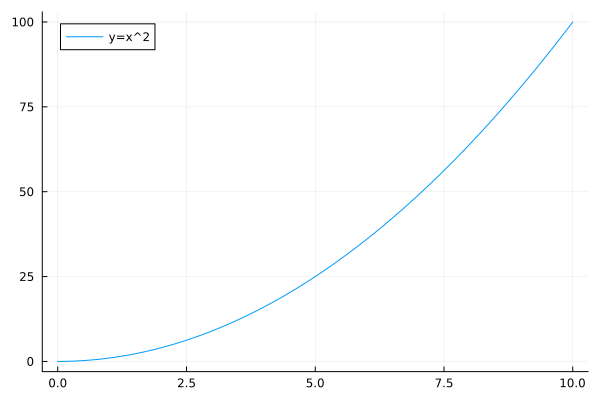

In [5]:
# Basic plotting
x = 0:0.1:10      # This is called a range.  
y = x .^ 2
plot(x,y,label="y=x^2")

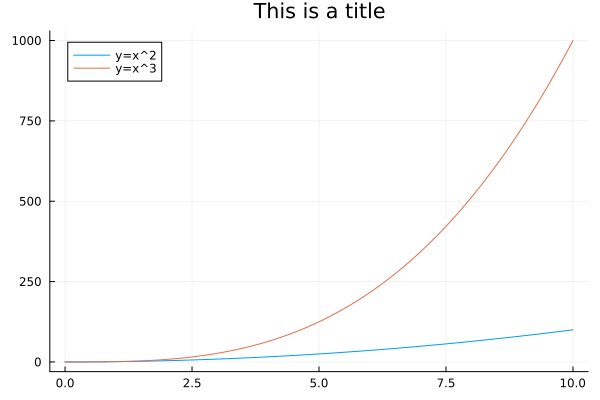

In [11]:
# There are two ways to plot multiple lines.  The first is to simply pass a vector of things to plot:
plot(x,[y,x.^3]; labels = ["y=x^2" "y=x^3"], title="This is a title")

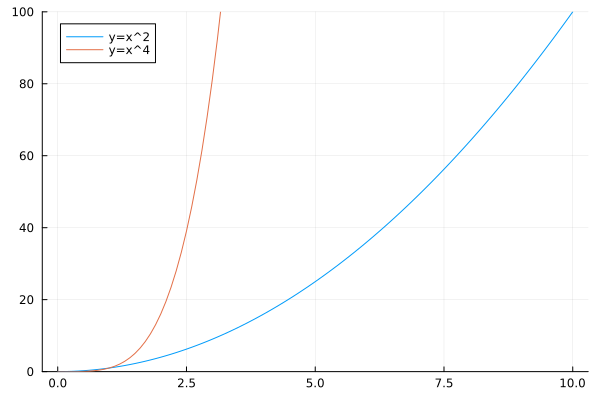

In [9]:
# The second is to use the function "plot!", which updates a plot:
p = plot(x,y,label="y=x^2")
plot!(p,x,x.^4,label="y=x^4",ylim=(0,100))

</hline>
<h1>Linear algebra</h1>
<h3>SVD and pinv</h3>

We now come to linear algebra.  The power of linear algebra is that it lets you reason geometrically about algebra, and it lets you reason algebraically about geometry.  We begin with the very useful singular value decomposition (SVD) and the related pseudo-inverse.

SVD breaks an arbitrary matrix into a composition of a rotation, a stretching (diagonal matrix), and another rotation.  More explicitly, SVD of an arbitrary matrix M is given by U*S*V', where U and V are rotation matrices, S is diagonal, and ' denotes the conjugate-transpose.  The singular values tell you a lot about the matrix, such as whether it is invertible, and they are usually sorted from largest to smallest.  (Remarkably, this works even if M is not a square matrix.  Question: What do you think it means for a non-square matrix to be "diagonal"?)

The pseudoinverse is the "closest to an inverse you can get".  If a matrix M is invertable, the pseudoinverse pinv(M) is just the regular inverse M^{-1}.  If M is not invertable but it is diagonal, then the pinv(M) is computed by inverting each non-zero diagonal element and leaving every other element zero.  In the general case, if the SVD of M is U*S*V', the pseudoinverse of M is V*pinv(S)*transpose(U). 

In [34]:
# Try to interpret geometrically what this matrix does.
M = [0 -2 0 ; 2 0 0 ; 0 0 0]
F = svd(M)

SVD{Float64, Float64, Matrix{Float64}, Vector{Float64}}
U factor:
3×3 Matrix{Float64}:
 -1.0   0.0  0.0
  0.0  -1.0  0.0
  0.0   0.0  1.0
singular values:
3-element Vector{Float64}:
 2.0
 2.0
 0.0
Vt factor:
3×3 Matrix{Float64}:
  0.0   1.0   0.0
 -1.0  -0.0  -0.0
  0.0   0.0   1.0

In [35]:
pinv(M)

3×3 Matrix{Float64}:
  0.0  0.5  0.0
 -0.5  0.0  0.0
  0.0  0.0  0.0

Below are some problems to get you familiar with pinv and SVD. 

In [ ]:
# Compute the pseudoinverse of the pseudoinverse of M, and interpret it. 

In [ ]:
# Extract the diagonal factor of svd(M), and turn it into a diagonal matrix. 

In [ ]:
# Find a matrix for which both rotations in the SVD are the identity matrix. 

In [ ]:
# Find a non-diagonal matrix for which the SVD diagonal factor has exactly one non-zero entry. 

In [ ]:
# Compute the determinant of a matrix using the diagonal factor of its SVD. 

In [ ]:
# Compute the SVD of a non-square matrix.  What are the shapes of the factors?  Why does this make sense?

<h3>Least squares</h3>

A very useful application of pinv is for computing linear least squares fits.  Suppose we have data with x-coordinates xs and y coordinates ys.  A least squares fit is a slope A and intercept b such that (ys - A*xs - b) is pretty small.  This can be rearranged into 

ys ≈ [xs ones(length(xs))] * [A, b], 

or 

[A,b] = pinv([xs ones(length(xs))]) * ys.

0.9457854009343065
0.01379983734901468


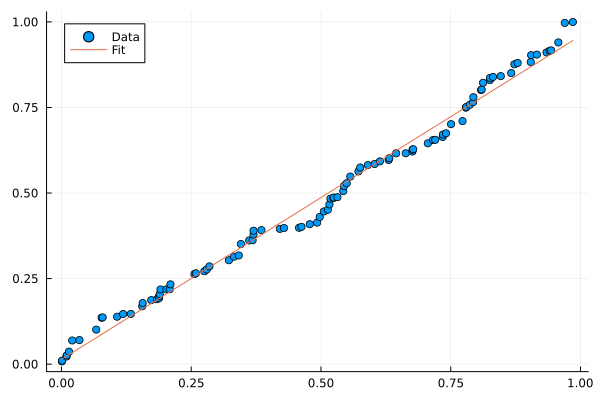

In [54]:
xs = sort(rand(100))
ys = sort(rand(100))
A,b = pinv([xs ones(length(xs))]) * ys
println(A)
println(b)
scatter(xs,ys,label="Data")
plot!(xs,A*xs .+ b,label="Fit")

There's a convenient shorthand for the pseudoinverse, using the operator \. 

In [55]:
A,b = [xs ones(length(xs))] \ ys

2-element Vector{Float64}:
 0.9457854009343064
 0.01379983734901451

<h3>Function spaces: Gaussian beam propagation</h3>

Arguably the most powerful application of linear algebra is to vector spaces of functions.  We will see how this works on a space of two-dimensional functions which model laser beam propagation. We begin by defining the Hermite-Gaussian modes, which are the most basic shapes that laser beams can assume.  

In [78]:
using SpecialPolynomials: Hermite, basis
# Define a 64x64 computational grid
N = 64
const grid = (-sqrt(N)/2:sqrt(1/N):sqrt(N)/2-sqrt(1/N), -sqrt(N)/2:sqrt(1/N):sqrt(N)/2-sqrt(1/N))

function HGMode(grid, n::Int, m::Int; waist::Float64=1.0, z::Float64=0.0, lam::Float64=1.0)
    return HG1D(grid[1],n;waist=waist,z=z,lam=lam) .* transpose(HG1D(grid[2],m;waist=waist,z=z,lam=lam))
end

function HG1D(grid, n::Int; waist::Float64=1.0, z::Float64=0.0, lam::Float64=1.0)
    zr = pi * waist^2 / lam
    q = z + im*zr
    w = waist*sqrt(1+(z/zr)^2)
    prefactor = sqrt(sqrt(2/pi)/(2^n * factorial(n) * waist)) * sqrt(1/(1-im*z/zr)) * sqrt(-conj(q)/q)^n
    polyfactor = basis(Hermite,n).(grid * sqrt(2) ./ w)
    expfactor = exp.(-2*pi*im * grid.^2 / (2*lam*q))
    return prefactor .* polyfactor .* expfactor
end

HG1D (generic function with 1 method)

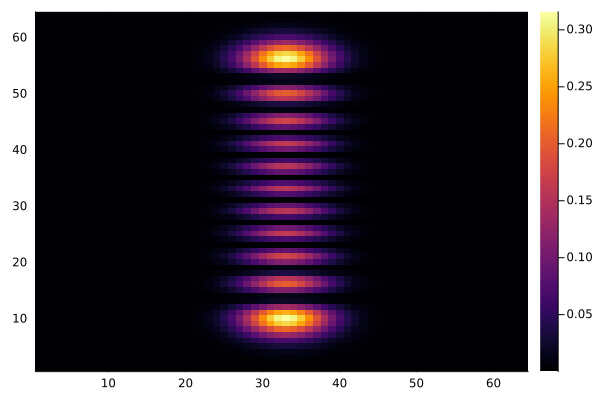

In [82]:
# Why do we need to take abs here? 
heatmap(abs.(HGMode(grid,10,0)).^2)

Hermite-Gaussian modes $H_{n,m}(x,y)$ form a basis for 2D functions.  This means that any 2D function can be written as a sum of the form
$$
\sum_{n,m} c_{n,m} H_{n,m}(x,y).
$$
But how do we determine the coefficients $c_{n,m}$?  The answer lies in the concept of *orthogonality*.  The integral of a product of two HG modes (one of them complex conjugated) is zero if the modes are different and 1 if they are the same,
$$
\int_{\mathbb{R}^2} H_{n,m}(x,y) H^{*}_{p,q}(x,y) \; dx \; dy = \delta_{np} \delta_{mq}.
$$

If some function $f(x,y)$ equals $\sum_{n,m} c_{n,m} H_{n,m}(x,y)$ for some choice of coefficients $c_{n,m}$, by multiplying both expressions against $H^{*}_{p,q}$ and integrating, we find
$$
c_{p,q} = \int_{\mathbb{R}^2} f(x,y) H^{*}_{p,q}(x,y) \; dx \; dy.
$$
You will implement this *mode decomposition* below for a function (represented as a matrix) sampled on the same grid as above. 

In [146]:
# Finish the code below to implement the overlap integral in the mode decomposition coefficient formula. 
# Numerical Recipes 4.1.3 has relevant integration formulas, though you can probably devise your own.
function HGOverlap(grid,f::Matrix{T},n::Int,m::Int; waist::Float64=1.0, z::Float64=0.0, lam::Float64=1.0) where {T<:Number}
    mode = HGMode(grid, n, m; waist=waist, z=z, lam=lam)
    integrand = f .* conj.(mode)
    bulk = sum(integrand)
    edges = sum(integrand[1,:]) + sum(integrand[end,:]) + sum(integrand[:,1]) + sum(integrand[:,end])
    corners = sum(integrand[1,1]) + sum(integrand[1,end]) + sum(integrand[end,1]) + sum(integrand[end,end])
    return (bulk - edges/2 + corners/4) * step(grid[1]) * step(grid[2])
end

LG01 = [exp(-x^2-y^2) * (1-2x^2-2y^2) for x in grid[1], y in grid[2]] * sqrt(2/pi)
coeffs = [HGOverlap(grid,LG01,n,m) for n=0:5,m=0:5]

6×6 Matrix{ComplexF64}:
  4.1231e-13+0.0im   1.19354e-12+0.0im  …   3.35978e-10+0.0im
 1.19427e-12+0.0im   2.21296e-18+0.0im      1.63045e-18+0.0im
   -0.707107+0.0im   2.82076e-14+0.0im      7.96967e-12+0.0im
 2.80774e-11+0.0im  -2.36062e-18+0.0im      9.93199e-19+0.0im
 1.45103e-10+0.0im   -3.3615e-18+0.0im     -7.61394e-19+0.0im
 3.35978e-10+0.0im  -1.13577e-18+0.0im  …  -1.30683e-19+0.0im

0.9999999999749631


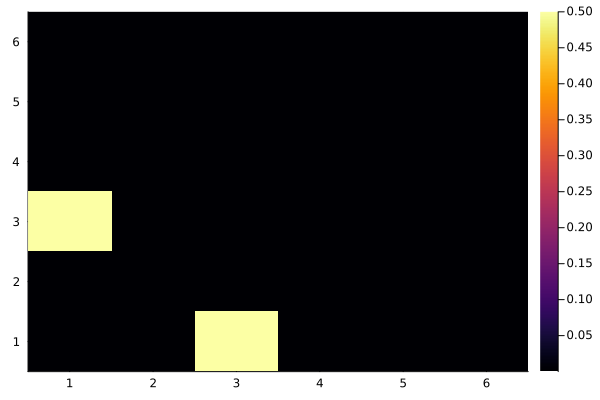

In [110]:
# If you coded the above correctly, the sum of squared absolute values of the coefficients should be one.  
sum(abs.(coeffs).^2) |> println
heatmap(abs.(coeffs).^2)        # This visually shows where the coefficients are large. 

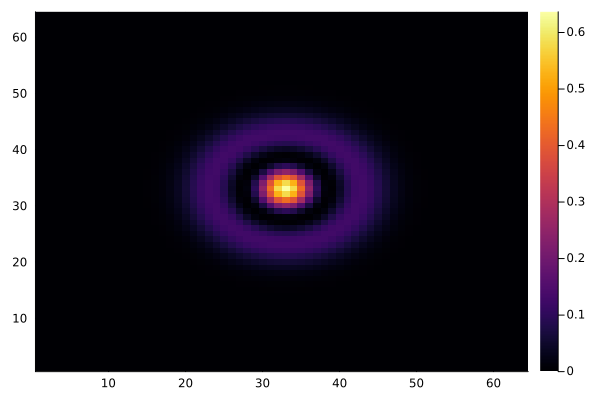

In [121]:
# Examine the form of the profile LG01. Then use the coefficients you found above and the HGMode function evaluated at z=4 
# to determine what a laser with initial profile LG01 will look like after propagating distance 4. 
heatmap(abs.(LG01_sampled).^2)

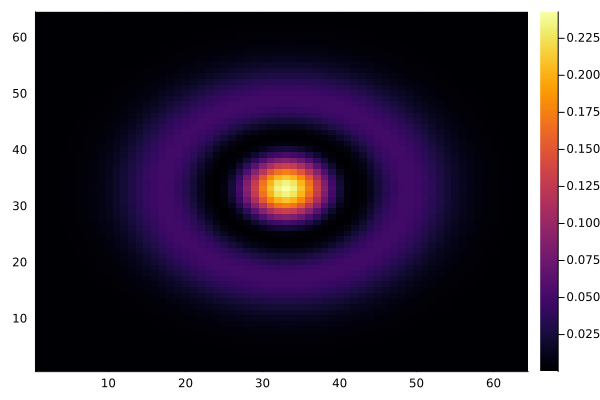

In [127]:
heatmap( abs.( -HGMode(grid,2,0;z=4.0)/sqrt(2) - HGMode(grid,0,2;z=4.0)/sqrt(2) ).^2 )